# Notebook 5: Generative Adversarial Networks

In this notebook we'll explore __Generative Adversarial Networks (GANs)__, a popular class of generative models developed in the past decade. Recall that in the previous notebook, we explored ways in which we could fool a fixed neural network classifier by optimizing its inputs. More specifically, we used the gradients of the classifier to craft perturbations in the input space that resulted in predictions of a chosen class. While our perturbations were small and somewhat noisy, one might wonder: _under certain conditions, might a gradient-guided perturbation actually cause an input to resemble an instance of the chosen class?_ Taking this idea to an extreme, we might start with random noise as an input and keep applying perturbations until we maximize the score of a particular class. Could we wind up with a "realistic" instance of that class?

This generally isn't the case with additive perturbations like those seen in the previous notebook; however, a very similar idea is at the core of GANs. In this notebook, we will show how simultaneously training two "competing" neural networks can allow us to produce synthetic instances that closely resemble an actual dataset. We'll start with a simple GAN architecture and the MNIST dataset to generate synthetic digits, and then try out a more powerful model on the FashionMNIST dataset to generate synthetic clothing. Finally, we'll explore common issues that arise when training GANs, and how to identify them.


The notebook is broken up as follows:

  1. [Setup](#setup)  
  2. [What Are GANs?](#intro)  
     2.1 [Theory and Motivation](#theory)  
     2.2 [A Simple MLP Architecture](#mlp)  
     2.3 [Generating Synthetic Digits](#mnist)  
     2.4 [Exploring the Latent Space](#latent)  
  3. [DCGAN: Adding Depth and Convolution](#dcgan)  
     3.1 [A (Transposed) Convolutional Architecture](#conv)  
     3.2 [Generating Synthetic Clothing](#fashionmnist)  
  4. [Debugging Your GAN](#debugging)  
     4.1 [Instability](#instability)  
     4.2 [Mode Collapse](#collapse)  
     4.3 [Failure to Converge](#converge)  

## __1.__ <a name="setup">Setup</a>


In [16]:
# helper code from the course repository
!git clone https://github.com/interactiveaudiolab/course-deep-learning.git
%cd course-deep-learning/
# install common pacakges used for deep learning
%pip install -r requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm

from utils.gan import *


%matplotlib inline

## __2.__ <a name="intro">What Are GANs?</a>

In this section, we'll introduce the general GAN architecture and implement a specific variant to generate synthetic digits. This tutorial is necessarily brief, but if you want to dive in deeper feel free to check out these resources:
* [GAN-MNIST-PyTorch](https://github.com/jsuarez5341/GAN-MNIST-Pytorch)
* [PyTorch DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
* [How to Identify and Diagnose GAN Failure Modes](https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/)

### __2.1__ <a name="theory">Theory and Motivation</a>
A generative adversarial network consists of two networks: a __generator__ and a __discriminator__. The generator network $G$ attempts to map samples $z$ from a noise distribution $p_z$ to instances of a dataset. The discriminator network $D$ attempts to distinguish between generated samples $G(z)$ and actual samples from the dataset $x \sim p_x$. These networks are trained in tandem:
* Samples are drawn from the dataset $x \sim p_x$
* Samples are drawn from the noise distribution $z \sim p_z$ and passed to the generator to create synthetic instances $G(z)$
* For all $x$, the discriminator predicts the probability $D(x)$ that the sample is drawn from the real dataset
* For all $G(z)$, the discriminator predicts the probability $D(G(z))$ that the sample is drawn from the real dataset


<br/>
<center>
<img width="600px" src="https://drive.google.com/uc?export=view&id=1INHALKJgCoI0H4aE8hFKe40_6_1MxPn5"/>
</center>
<br/>


At this point, the generator and discriminator have competing objectives: the generator succeeds in creating "realistic" samples when $D(G(z))$ is high, and the discriminator succeeds in distinguishing samples when $D(G(z))$ is low and $D(x)$ is high. The theory behind GANs is that when we allow the networks to optimize these competing objectives, they will converge to an equilibrium in which the generator produces high-quality samples that the discriminator cannot distinguish from real data. In their paper introducing GANs, 
[Goodfellow et al. (2014)](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf) formulate this adversarial optimization as follows:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_x} \left[\log D(x) \right] + \mathbb{E}_{z \sim p_z} \left[\log \left(1 - D\left(G(z)\right)\right) \right]$$

While this minimax objective looks tricky to deal with, in practice we can avoid its nested dependencies by simply optimizing the generator and discriminator in turns. Even better, we can express the objectives of the generator and discriminator using PyTorch's built-in __binary cross-entropy loss__. For a target $y \in \{0, 1\}$ and prediction $y' \in [0, 1]$, the binary cross-entropy loss is defined as

$$\mathrm{BCE}(y, y') = - \left[ y \cdot \log y' + (1 - y) \cdot \log(1 - y') \right]$$

Given a batch of real data $x$ and synthetic data $G(z)$, let's start by training the discriminator. We'll set $y = 1$ for all real $x$ and $y = 0$ for all generated $G(z)$, and take the output of our discriminator $D$ as our prediction $y'$. Plugging in, our discriminator loss becomes 

$$
\begin{align*}
\mathrm{BCE}_{\mathrm{total}} &= \mathrm{BCE}_{\mathrm{real}} + \mathrm{BCE}_{\mathrm{generated}} \\
 &= \mathrm{BCE}(1, D(x)) + \mathrm{BCE}(0, D(G(z))) \\
 &= -\left[1 \cdot \log D(x) + 0 \cdot \log(1 - D(x))\right] - \left[0 \cdot \log D(G(z)) + 1 \cdot \log(1 - D(G(z)))\right] \\ 
 &= -\log D(x) - \log(1 - D(G(z)))
\end{align*}
$$

Note that this rewards a high $D(x)$ and penalizes a high $D(G(z))$, aligning with the discriminator's objective. Once we've performed a training step with the discriminator, we can do the same with the generator, this time using the "real" label $y = 1$ as our target for the discriminator's output:

$$
\begin{align*}
\mathrm{BCE}_{\mathrm{total}} &= \mathrm{BCE}_{\mathrm{generated}} \\
 &= \mathrm{BCE}(1, D(G(z))) \\
 &= -\left[1 \cdot \log D(G(z)) + 0 \cdot \log(1 - D(G(z)))\right]\\ 
 &= -\log D(G(z))
\end{align*}
$$

This rewards a high $D(G(z))$, aligning with the generator's objective. And that's GAN training in a nutshell -- we'll simply compute a cross-entropy loss for the discriminator and then the generator at every iteration, followed by a gradient-based update to the weights of each model. We'll start with a simple architecture for our generator and discriminator networks, and train on the MNIST dataset to produce synthetic digits.

### __2.2__ <a name="mlp">A Simple MLP Architecture</a>

Our generator and discriminator networks will be simple multi-layer perceptrons. The generator network will map latents (random Gaussian noise) to a vector of size 784 (the number of pixels in an MNIST image). The discriminator will map MNIST images (flattened to 784-dimensional vectors) to a scalar probability that the image is real. To ensure stability, we will use the same number of layers and layer dimensions in both networks.

In [103]:
class MLPGenerator(torch.nn.Module):
    
    def __init__(self, 
                 depth: int, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP generator"""
        
        super().__init__()
        
        assert depth >= 1, "Generator depth must be at least 1"
        
        dims_in = [input_size] + [hidden_size] * (depth - 1)
        dims_out = [hidden_size] * (depth - 1) + [output_size]
        
        layers = []
        for i in range(depth):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < depth - 1:
                layers.append(activation)
        
        # apply Sigmoid after final layer to constrain generated images to [0, 1]
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)


class MLPDiscriminator(torch.nn.Module):
    
    def __init__(self, 
                 depth: int, 
                 input_size: int, 
                 hidden_size: int, 
                 activation: torch.nn.Module):
        """Construct a simple MLP discriminator"""
        
        super().__init__()
        
        assert depth >= 1, "Discriminator depth must be at least 1"
        
        dims_in = [input_size] + [hidden_size] * (depth - 1)
        dims_out = [hidden_size] * (depth - 1) + [1]  # final output is scalar (probability)
        
        layers = []
        for i in range(depth):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < depth - 1:
                layers.append(activation)
        
        # apply sigmoid after final layer to represent probability
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)


class MLPGAN(torch.nn.Module):
                          
    def __init__(self, 
                 depth: int, 
                 latent_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 activation_generator: torch.nn.Module = torch.nn.ReLU(),
                 activation_discriminator: torch.nn.Module = torch.nn.LeakyReLU(0.2)
                ):
        """Construct a simple MLP generative adversarial network"""
        super().__init__()
                          
        self.generator = MLPGenerator(
            depth=depth, 
            input_size=latent_size, 
            hidden_size=hidden_size, 
            output_size=output_size,
            activation=activation_generator
        )
        
        self.discriminator = MLPDiscriminator(
            depth=depth, 
            input_size=output_size, 
            hidden_size=hidden_size,
            activation=activation_discriminator
        )    

### __2.3__ <a name="mnist">Generating Synthetic Digits</a>

Now it's time to train our GAN! As discussed above, we'll alternate between updating the generator and discriminator networks. To keep track of training progress, we'll use TensorBoard (see Notebook 3).

#### Training Configuration

In [144]:
# here, we'll initialize TensorBoard. You should see an empty window in this cell, which will populate with
# graphs as soon as we run our training code below.
%load_ext tensorboard
%tensorboard --logdir logs --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
# GAN training hyperparameters
image_size = 28
batch_size = 64
latent_size = 64
hidden_size = 256
depth = 3
lr = 0.0002
epochs = 80

# fix random seed
torch.manual_seed(0)

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load MNIST dataset
mnist = load_mnist(batch_size=batch_size)

# initialize the model
gan = MLPGAN(
    depth=depth, 
    latent_size=latent_size, 
    hidden_size=hidden_size, 
    output_size=image_size*image_size, 
).to(device)

# use an optimizer to handle parameter updates
opt_discriminator = torch.optim.Adam(gan.discriminator.parameters(), lr=lr)
opt_generator = torch.optim.Adam(gan.generator.parameters(), lr=lr)

# loss function: binary cross-entropy loss
loss = torch.nn.BCELoss()

# determine which labels will correspond to "real" and "fake" predictions from the discriminator
label_real = 1.0
label_fake = 0.0

# select a fixed set of latents which we will use to visualize the GAN's generation quality each epoch
fixed_latents = torch.randn((batch_size, latent_size)).to(device)

# save all log data to a local directory
run_dir = "logs"

# to clear out TensorBoard and start totally fresh, we'll need to
# remove old logs by deleting them from the directory
!rm -rf ./logs/

# timestamp the logs for each run so we can sort through them 
run_time = datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y")

# initialize a SummaryWriter object to handle all logging actions
logger = SummaryWriter(log_dir=Path(run_dir) / run_time, flush_secs=20)

# plot example training images
batch, _ = next(iter(mnist))
logger.add_image("training_images", make_grid(batch, math.floor(math.sqrt(batch_size))), 0)

#### Training Loop

We're ready to train! Check out the TensorBoard cell above to view training results in real time (you may need to periodically refresh using the icon in the upper right corner). If you're using Google Colab with a GPU enabled, training through all 80 epochs should take around ten minutes.

In [6]:
# log metrics
loss_d = np.zeros(epochs)
loss_g = np.zeros(epochs)
score_real = np.zeros(epochs)
score_fake = np.zeros(epochs)

for epoch in range(epochs):
    
    # weight batch losses/scores proportional to batch size
    iter_count = 0

    for batch_idx, batch_data in enumerate(mnist):

        # we only care about inputs, not labels
        x_real, _ = batch_data
        
        # flatten input images and move to device
        x_real = x_real.to(device)
        n_batch = x_real.shape[0]
        x_real = x_real.reshape(n_batch, -1)
        
        ########################################################################
        # STEP 1: train the discriminator network to maximize the objective
        #         log(D(x)) + log(1 - D(G(z)))
        ########################################################################
        
        gan.discriminator.zero_grad()
        
        # train on a batch of real inputs
        y_real = torch.full((n_batch, 1), label_real, device=device)
        preds_real = gan.discriminator(x_real)
        loss_real = loss(preds_real, y_real)
        
        # train on a batch of synthesized inputs
        z = torch.randn(n_batch, latent_size).to(device)
        x_fake = gan.generator(z)
        y_fake = torch.full((n_batch, 1), label_fake, device=device)
        preds_fake = gan.discriminator(x_fake.detach())  # exclude generator from gradient computation
        loss_fake = loss(preds_fake, y_fake)
        
        # update discriminator weights
        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        opt_discriminator.step()
        
        ########################################################################
        # STEP 2: train the generator network to minimize the objective 
        #         log(1 - D(G(z))), or equivalently, to maximize D(G(z))
        ########################################################################
        
        gan.generator.zero_grad()
        
        # train on a batch of synthesized inputs
        z = torch.randn(n_batch, latent_size).to(device)
        x_fake = gan.generator(z)
        preds_fake = gan.discriminator(x_fake)
        loss_generator = loss(preds_fake, y_real)
        loss_generator.backward()
        
        # update generator weights
        opt_generator.step()
        
        # log losses and scores
        loss_d[epoch] += loss_discriminator.detach().item() * n_batch
        loss_g[epoch] += loss_generator.detach().item() * n_batch
        score_real[epoch] += preds_real.mean().detach().item() * n_batch
        score_fake[epoch] += preds_fake.mean().detach().item() * n_batch
        
        iter_count += n_batch
    
    # plot generator and discriminator losses
    loss_d[epoch] /= iter_count
    loss_g[epoch] /= iter_count
    logger.add_image("training_loss", make_loss_plot(epochs, loss_d, loss_g), epoch)
    
    # plot discriminator scores
    score_real[epoch] /= iter_count
    score_fake[epoch] /= iter_count
    logger.add_image("discriminator_scores", make_score_plot(epochs, score_real, score_fake), epoch)
    
    # plot example generated images
    with torch.no_grad():
        generated = gan.generator(fixed_latents).reshape(batch_size, 1, image_size, image_size)
        logger.add_image("generated_images", make_grid(generated, math.floor(math.sqrt(batch_size)), title="Generated Images"), epoch)
    
    if not epoch % 10:
        print(f"Epoch: {epoch + 1}\tDiscriminator Loss: {loss_d[epoch] :0.4f}\tGenerator Loss: {loss_g[epoch] :0.4f}")

Epoch: 1	Discriminator Loss: 0.1494	Generator Loss: 5.1723
Epoch: 11	Discriminator Loss: 0.0781	Generator Loss: 6.6027
Epoch: 21	Discriminator Loss: 0.2328	Generator Loss: 4.4751
Epoch: 31	Discriminator Loss: 0.5757	Generator Loss: 2.4149
Epoch: 41	Discriminator Loss: 0.6727	Generator Loss: 2.0176
Epoch: 51	Discriminator Loss: 0.6851	Generator Loss: 1.9279
Epoch: 61	Discriminator Loss: 0.7033	Generator Loss: 1.8930
Epoch: 71	Discriminator Loss: 0.6941	Generator Loss: 1.8980


### __2.4__ <a name="latent">Exploring the Latent Space</a>

We've got a GAN! Our network is now trained to map standard Gaussian noise to MNIST-style digits! To see for yourself, try running the cell below a few times:

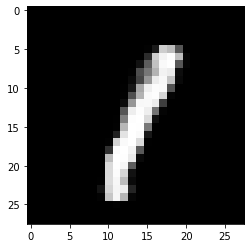

In [130]:
z = torch.randn(1, latent_size).to(device)
output = gan.generator(z).reshape(image_size, image_size)
plt.imshow(output.detach().cpu().numpy(), cmap='gray')
plt.show()

Note that our GAN has only learned this mapping for inputs from the latent distribution $\mathcal{N}(0, 1)$. For example, if we feed it an "out-of-distribution" latent input, we might end up with slightly wacky results:

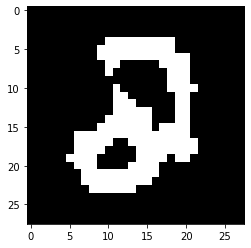

In [131]:
z = torch.full((1, latent_size), 1000.0).to(device)
output = gan.generator(z).reshape(image_size, image_size)
plt.imshow(output.detach().cpu().numpy(), cmap='gray')
plt.show()

Because our GAN has learned to map high-likelihood points under our latent distribution to realistic digits, we can do lots of cool things -- for example, smoothly interpolating between digits by traversing the latent space. The code below will generate a GIF file `latent_walk.gif`

In [142]:
%%capture

fig = plt.figure()

# the number of steps we will take between two latent points
n_steps = 20

# randomly sample two points from the latent distribution
point1 = torch.randn(1, latent_size).to(device)
point2 = torch.randn(1, latent_size).to(device)

# initial plot
img = gan.generator(point1).view(28, 28)
im = plt.imshow(img.detach().cpu().numpy(), cmap='gray')

def init():
    im.set_data(gan.generator(point1).view(28, 28).detach().cpu().numpy())
    return [im]

def animate(i):
    # interpolate between points in the latent space and pass through the generator
    point = (i/n_steps) * (point2 - point1) + point1
    img = gan.generator(point).view(28, 28)
    im.set_array(img.detach().cpu().numpy())
    return [im]

# create an animated GIF and save
anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=30, blit=True)
anim.save('latent_walk.gif', fps=30)

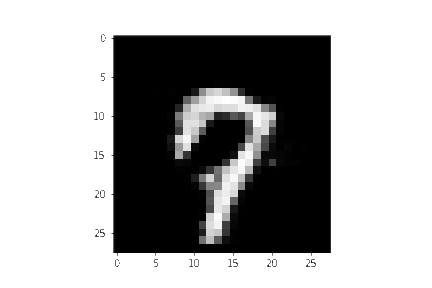

In [143]:
# run this to view your GIF
ipd.Image(open('latent_walk.gif','rb').read())

We can also put our adversarial example knowledge from Notebook 4 to use, and optimize an input to our generator such that the generated image is close to an actual image from the MNIST dataset! To see how, we'll start with a random MNIST image:

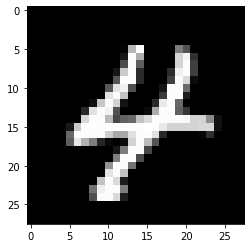

In [117]:
batch, labels = next(iter(mnist))
example_img, example_label = batch[0], labels[0]
plt.imshow(example_img.reshape(image_size, image_size), cmap='gray')
plt.show()

This will be our "target," i.e. what we want to steer our generator's output towards. To do this, we need a loss function to penalize the "distance" between our generator's output and the example image. One option is to simply use the mean squared error between a generated image and our example. This is a pretty rough metric, and so it may take a few tries to find an image that looks like our example. We'll use the same basic "adversarial" loop as in Notebook 4, optimizing an additive perturbation of a latent (noise) vector that will be passed through the generator until its output matches our example image.

MSE Loss: 86.2666
MSE Loss: 23.0644
MSE Loss: 20.4549
MSE Loss: 20.0514
MSE Loss: 19.1722
MSE Loss: 19.6517
MSE Loss: 20.2240
MSE Loss: 17.0684
MSE Loss: 17.8127
MSE Loss: 17.3536


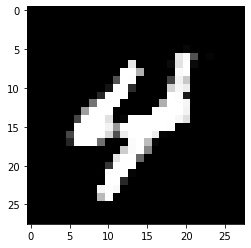

In [124]:
# optimize a latent vector such that when passing it through the generator, the output looks like out image
z = torch.randn(1, latent_size).to(device).requires_grad_(True)

for i in range(10000):
    
    z.grad = None
    
    output = gan.generator(z)
    
    matching_loss = torch.square(output.reshape(-1) - example_img.reshape(-1).to(device)).sum()
    matching_loss.backward()
    
    grad = z.grad.detach()
    
    with torch.no_grad():
        z -= grad/grad.norm().item()
    
    # plot generated image
    if not i % 1000:
        print(f"MSE Loss: {matching_loss.item() :0.4f}")
        #plt.imshow(output.detach().cpu().reshape(image_size, image_size), cmap='gray')
        #plt.show()

plt.imshow(output.detach().cpu().reshape(image_size, image_size), cmap='gray')
plt.show()

And that's it for our basic GAN! Next, we'll consider a more complex dataset and GAN architecture.

## __3.__ <a name="dcgan">DCGAN: Adding Depth and Convolution</a>

While our MLP-based GAN was able to successfully generate MNIST digits, it took a long time to converge. Part of the issue with our GAN was its "naive" approach to representing and processing the data -- recall that we dealt with images as "flattened" pixel vectors. When we pass a flattened image to a fully-connected network layer (i.e. a perceptron), it can be difficult for the network to focus on relevant __spatial information__ because every hidden unit receives independent input from every pixel. Similarly, when generating images with fully-connected layers, it can be difficult to represent local structure because every hidden unit is linked independently to every pixel in the output image. Ideally, we might modify the generator and discriminator networks so that certain hidden units can focus on specific local patterns, such as edges.

### __3.1__ <a name="conv">A (Transposed) Convolutional Architecture</a>

A popular architecture addressing these shortcomings, proposed by [Radford et al. (2016)](https://arxiv.org/pdf/1511.06434.pdf), is DCGAN (short for Deep Convolutional GAN). DCGAN uses a __convolutional__ neural network generator and correspondingly, a __transposed convolutional__ neural network discriminator (which the authors refer to as "fractionally-strided convolution"). Combined with batch normalization, this allows for a larger network capable of representing more complex image data while converging more rapidly.

In [101]:
class DCDiscriminator(torch.nn.Module):
    
    def __init__(self, hidden_size: int):
        """
        Given images with spatial dimensions (1, 28, 28), produce a scalar probability
        that each image is real.
        
        (n_batch, 1, 28, 28) --> (n_batch, 1)
        """
        
        super().__init__()
        
        self.net = torch.nn.Sequential(
            
            # input: (n_batch, 1, 28, 28) 
            
            torch.nn.Conv2d(
                in_channels=1, 
                out_channels=hidden_size, 
                kernel_size=4,
                stride=2,
                padding=1, 
                bias=False
            ),
            torch.nn.LeakyReLU(0.2, inplace=True),
            
            # intermediate representation: (n_batch, hidden_size, 14, 14)
            
            torch.nn.Conv2d(
                in_channels=hidden_size,
                out_channels=hidden_size * 2, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            torch.nn.BatchNorm2d(hidden_size * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            
            # intermediate representation: (n_batch, hidden_size*2, 7, 7)
            
            torch.nn.Conv2d(
                in_channels=hidden_size * 2,
                out_channels=hidden_size * 4, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            torch.nn.BatchNorm2d(hidden_size * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            
            # intermediate representation: (n_batch, hidden_size*4, 3, 3)
            
            torch.nn.Conv2d(
                in_channels=hidden_size * 4, 
                out_channels=1, 
                kernel_size=3, 
                stride=1, 
                padding=0, 
                bias=False
            ),
            torch.nn.Sigmoid()
            
            # intermediate representation: (n_batch, 1, 1, 1)
        )
    
    def forward(self, x: torch.Tensor):
        
        assert x.ndim >=2
        n_batch = x.shape[0]
        
        return self.net(x).reshape(n_batch, 1)
    

class DCGenerator(torch.nn.Module):
    
    def __init__(self, latent_size: int, hidden_size: int):
        """
        Unlike our MLP generator, we'll interpret our latent inputs as having three 
        (non-batch) dimensions: channels, height, and width. Our latents will start
        with only a nontrivial channel dimension, and we will gradually reshape them 
        to "spread out" over the height and width dimensions using transposed 
        convolutions.       
        
        (n_batch, latent_size, 1, 1) --> (n_batch, 1, 28, 28)
        """

        super().__init__()
        
        self.net = torch.nn.Sequential(
            
            # input: (n_batch, latent_size, 1, 1)
            
            torch.nn.ConvTranspose2d(
                in_channels=latent_size, 
                out_channels=hidden_size * 4, 
                kernel_size=4, 
                stride=1, 
                padding=0, 
                bias=False
            ),
            torch.nn.BatchNorm2d(hidden_size * 4),
            torch.nn.ReLU(True),
            
            # intermediate representation: (n_batch, hidden_size*4, 4, 4)

             torch.nn.ConvTranspose2d(
                in_channels=hidden_size * 4, 
                out_channels=hidden_size * 2, 
                kernel_size=3, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            torch.nn.BatchNorm2d(hidden_size * 2),
            torch.nn.ReLU(True),
            
            # intermediate representation: (n_batch, hidden_size*2, 7, 7)
            
            torch.nn.ConvTranspose2d(
                in_channels=hidden_size * 2, 
                out_channels=hidden_size, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            torch.nn.BatchNorm2d(hidden_size),
            torch.nn.ReLU(True),
            
            # intermediate representation: (n_batch, hidden_size, 14, 14)
            
            torch.nn.ConvTranspose2d(
                in_channels=hidden_size, 
                out_channels=1, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            torch.nn.Sigmoid()
            
            # intermediate representation: (n_batch, 1, 28, 28) 
        )
    
    def forward(self, z: torch.Tensor):
        
        # ensure latents are correct shape (channels-only)
        assert z.ndim >= 2
        n_batch = z.shape[0]
        z = z.reshape(n_batch, -1, 1, 1)
        
        return self.net(z)
    
    
class DCGAN(torch.nn.Module):
    
    def __init__(self, latent_size: int, hidden_size: int):
        """
        Finally, we can combine our convolutional generator and discriminator networks.
        """
        
        super().__init__()
        
        self.generator = DCGenerator(latent_size=latent_size, hidden_size=hidden_size)
        self.discriminator = DCDiscriminator(hidden_size=hidden_size)
    
        # initialize weights
        for m in self.modules():

            name = m.__class__.__name__

            if name.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)

            elif name.find('BatchNorm') != -1:
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)

### __3.2__ <a name="fashionmnist">Generating Synthetic Clothing</a>

We'll demonstrate the capacity of DCGAN by generating articles of clothing from the FashionMNIST dataset.

#### Training Configuration

In [102]:
# here, we'll initialize TensorBoard. You should see an empty window in this cell, which will populate with
# graphs as soon as we run our training code below.
%load_ext tensorboard
%tensorboard --logdir logs --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 672558), started 0:28:27 ago. (Use '!kill 672558' to kill it.)

In [99]:
# GAN training hyperparameters
image_size = 28
batch_size = 64
latent_size = 64
hidden_size = 64
lr = 0.0002
epochs = 10

# fix random seed
torch.manual_seed(0)

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load FashionMNIST dataset
fashionmnist = load_fashionmnist(batch_size=batch_size)

# initialize the model
dcgan = DCGAN(
    latent_size=latent_size, 
    hidden_size=hidden_size, 
).to(device)
dcgan.train()

# use an optimizer to handle parameter updates
opt_discriminator = torch.optim.Adam(dcgan.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_generator = torch.optim.Adam(dcgan.generator.parameters(), lr=lr, betas=(0.5, 0.999))

# loss function: binary cross-entropy loss
loss = torch.nn.BCELoss()

# determine which labels will correspond to "real" and "fake" predictions from the discriminator
label_real = 1.0
label_fake = 0.0

# select a fixed set of latents which we will use to visualize the GAN's generation quality each epoch
fixed_latents = torch.randn((batch_size, latent_size)).to(device)

# save all log data to a local directory
run_dir = "logs"

# timestamp the logs for each run so we can sort through them 
run_time = datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y")

# initialize a SummaryWriter object to handle all logging actions
logger = SummaryWriter(log_dir=Path(run_dir) / run_time, flush_secs=20)

# plot example training images
batch, _ = next(iter(fashionmnist))
logger.add_image("training_images", make_grid(batch, math.floor(math.sqrt(batch_size))), 0)

#### Training Loop

Check out the TensorBoard cell above to view training results in real time (you may need to periodically refresh using the icon in the upper right corner). If you're using Google Colab with a GPU enabled, training through all 10 epochs should take only a few minutes.

In [100]:
# log metrics
loss_d = np.zeros(epochs)
loss_g = np.zeros(epochs)
score_real = np.zeros(epochs)
score_fake = np.zeros(epochs)

for epoch in range(epochs):
    
    # weight batch losses/scores proportional to batch size
    iter_count = 0

    for batch_idx, batch_data in enumerate(fashionmnist):

        # we only care about inputs, not labels
        x_real, _ = batch_data
        
        # flatten input images and move to device
        n_batch = x_real.shape[0]
        x_real = x_real.reshape(n_batch, 1, image_size, image_size).to(device)
        
        ########################################################################
        # STEP 1: train the discriminator network to maximize the objective
        #         log(D(x)) + log(1 - D(G(z)))
        ########################################################################
        
        dcgan.discriminator.zero_grad()
        
        # train on a batch of real inputs
        y_real = torch.full((n_batch, 1), label_real, device=device)
        preds_real = dcgan.discriminator(x_real)
        loss_real = loss(preds_real, y_real)
        
        # train on a batch of synthesized inputs
        z = torch.randn(n_batch, latent_size).to(device)
        x_fake = dcgan.generator(z)
        y_fake = torch.full((n_batch, 1), label_fake, device=device)
        preds_fake = dcgan.discriminator(x_fake.detach())  # exclude generator from gradient computation
        loss_fake = loss(preds_fake, y_fake)
        
        # update discriminator weights
        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        opt_discriminator.step()
        
        ########################################################################
        # STEP 2: train the generator network to minimize the objective 
        #         log(1 - D(G(z))), or equivalently, to maximize D(G(z))
        ########################################################################
        
        dcgan.generator.zero_grad()
        
        # train on a batch of synthesized inputs
        z = torch.randn(n_batch, latent_size).to(device)
        x_fake = dcgan.generator(z)
        preds_fake = dcgan.discriminator(x_fake)
        loss_generator = loss(preds_fake, y_real)
        loss_generator.backward()
        
        # update generator weights
        opt_generator.step()
        
        # log losses and scores
        loss_d[epoch] += loss_discriminator.detach().item() * n_batch
        loss_g[epoch] += loss_generator.detach().item() * n_batch
        score_real[epoch] += preds_real.mean().detach().item() * n_batch
        score_fake[epoch] += preds_fake.mean().detach().item() * n_batch
        
        iter_count += n_batch
    
    # plot generator and discriminator losses
    loss_d[epoch] /= iter_count
    loss_g[epoch] /= iter_count
    logger.add_image("training_loss", make_loss_plot(epochs, loss_d, loss_g), epoch)
    
    # plot discriminator scores
    score_real[epoch] /= iter_count
    score_fake[epoch] /= iter_count
    logger.add_image("discriminator_scores", make_score_plot(epochs, score_real, score_fake), epoch)
    
    # plot example generated images
    with torch.no_grad():
        generated = dcgan.generator(fixed_latents).reshape(batch_size, 1, image_size, image_size)
        logger.add_image("generated_images", make_grid(generated, math.floor(math.sqrt(batch_size)), title="Generated Images"), epoch)
    
    # log losses
    print(f"Epoch: {epoch + 1}\tDiscriminator Loss: {loss_d[epoch] :0.4f}\tGenerator Loss: {loss_g[epoch] :0.4f}")

Epoch: 1	Discriminator Loss: 0.3543	Generator Loss: 3.3541


As we can see, our DCGAN is capable of learning to generate FashionMNIST images in a relatively small number of epochs. But while our experiments so far may paint a rosy picture of GANs, in practice these architectures are often prone to a number of specific issues. In the next section, we'll briefly examine some common bugs that can arise when training GANs.

## __4.__ <a name="debugging">Debugging Your GAN</a>

### __4.1__ <a name="instability">Instability</a>

### __4.2__ <a name="collapse">Mode Collapse</a>

### __4.3__ <a name="converge">Failure to Converge</a>